# Phase 4: 객체 인식

이 노트북에서 배울 내용:
- 기하학적 특징 추출
- FPFH 특징 추출
- 규칙 기반 분류
- 머신러닝 분류기 (SVM)

In [1]:
import sys
sys.path.append('..')

import numpy as np
import open3d as o3d

from src.data import PointCloudLoader
from src.preprocessing import Preprocessor
from src.segmentation import Segmenter
from src.recognition import PointCloudClassifier, FeatureExtractor
from src.recognition.classifier import SimpleRuleClassifier
from src.utils import Visualizer

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 1. 학습 데이터 생성

In [2]:
loader = PointCloudLoader()

# 각 클래스별 샘플 생성
def generate_samples(n_samples=20):
    """학습용 샘플 생성"""
    samples = []
    labels = []
    
    for i in range(n_samples):
        # 박스 (다양한 크기)
        size = np.random.uniform(0.3, 1.0)
        box = loader.create_sample_box(
            center=(0, 0, 0),
            size=(size, size * np.random.uniform(0.8, 1.2), size * np.random.uniform(0.8, 1.2)),
            density=500
        )
        samples.append(box)
        labels.append("box")
        
        # 구 (다양한 크기)
        radius = np.random.uniform(0.2, 0.6)
        sphere = loader.create_sample_sphere(
            center=(0, 0, 0),
            radius=radius,
            n_points=500
        )
        samples.append(sphere)
        labels.append("sphere")
    
    return samples, labels

samples, labels = generate_samples(20)
print(f"생성된 샘플: {len(samples)}개")
print(f"클래스: {set(labels)}")

생성된 샘플: 40개
클래스: {'box', 'sphere'}


## 2. 기하학적 특징 추출

In [3]:
feature_extractor = FeatureExtractor()

# 박스 특징
box_features = feature_extractor.extract_geometric_features(samples[0])
print("박스 특징:")
for key, value in box_features.items():
    if isinstance(value, list):
        print(f"  {key}: [{value[0]:.3f}, {value[1]:.3f}, {value[2]:.3f}]")
    else:
        print(f"  {key}: {value:.3f}")

박스 특징:
  n_points: 486.000
  width: 0.833
  height: 0.726
  depth: 0.733
  volume: 0.444
  surface_area: 3.497
  aspect_ratio_xy: 1.148
  aspect_ratio_xz: 1.136
  aspect_ratio_yz: 0.990
  centroid: [0.011, 0.003, -0.005]
  variance: [0.093, 0.072, 0.072]
  linearity: 0.218
  planarity: 0.108
  sphericity: 0.674


In [4]:
# 구 특징
sphere_features = feature_extractor.extract_geometric_features(samples[1])
print("구 특징:")
for key, value in sphere_features.items():
    if isinstance(value, list):
        print(f"  {key}: [{value[0]:.3f}, {value[1]:.3f}, {value[2]:.3f}]")
    else:
        print(f"  {key}: {value:.3f}")

구 특징:
  n_points: 500.000
  width: 0.887
  height: 0.886
  depth: 0.887
  volume: 0.697
  surface_area: 4.717
  aspect_ratio_xy: 1.002
  aspect_ratio_xz: 1.000
  aspect_ratio_yz: 0.998
  centroid: [0.011, -0.004, 0.008]
  variance: [0.070, 0.063, 0.065]
  linearity: 0.028
  planarity: 0.145
  sphericity: 0.826


In [5]:
# 핵심 특징 비교
print("\n=== 형상 특징 비교 ===")
print(f"               박스      구")
print(f"Linearity:    {box_features['linearity']:.3f}   {sphere_features['linearity']:.3f}")
print(f"Planarity:    {box_features['planarity']:.3f}   {sphere_features['planarity']:.3f}")
print(f"Sphericity:   {box_features['sphericity']:.3f}   {sphere_features['sphericity']:.3f}")

# 구는 sphericity가 높고, 박스는 planarity가 높은 경향


=== 형상 특징 비교 ===
               박스      구
Linearity:    0.218   0.028
Planarity:    0.108   0.145
Sphericity:   0.674   0.826


## 3. FPFH 특징 추출

In [6]:
# FPFH: 33차원 히스토그램 특징
fpfh_box = feature_extractor.extract_global_fpfh(samples[0])
fpfh_sphere = feature_extractor.extract_global_fpfh(samples[1])

print(f"FPFH 차원: {len(fpfh_box)}")
print(f"박스 FPFH (처음 5개): {fpfh_box[:5]}")
print(f"구 FPFH (처음 5개): {fpfh_sphere[:5]}")

FPFH 차원: 33
박스 FPFH (처음 5개): [20.2693958   5.34405584 14.60699914  4.87409871 10.62675891]
구 FPFH (처음 5개): [3.07531118e+01 4.24259283e+00 2.48030528e-02 6.61488051e-01
 5.14348878e+01]


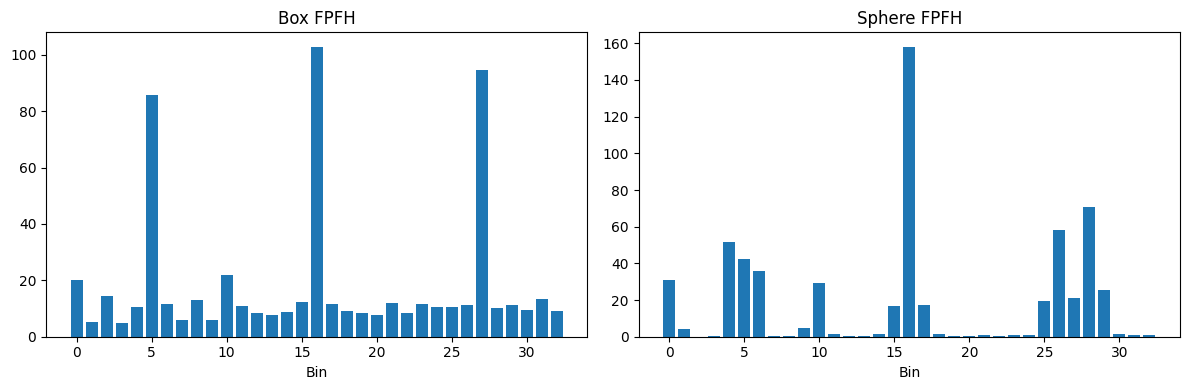

In [7]:
# FPFH 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(range(33), fpfh_box)
plt.title('Box FPFH')
plt.xlabel('Bin')

plt.subplot(1, 2, 2)
plt.bar(range(33), fpfh_sphere)
plt.title('Sphere FPFH')
plt.xlabel('Bin')

plt.tight_layout()
plt.show()

## 4. 규칙 기반 분류

In [8]:
# 규칙 기반 분류기 (학습 불필요)
rule_classifier = SimpleRuleClassifier()

# 테스트
for i, (sample, label) in enumerate(zip(samples[:4], labels[:4])):
    pred, scores = rule_classifier.classify(sample)
    print(f"샘플 {i+1} (실제: {label}): 예측 = {pred}")
    print(f"  점수: {scores}")
    print()

샘플 1 (실제: box): 예측 = sphere
  점수: {'plane': 0.0, 'sphere': 0.6738849077529036, 'box': 0.0, 'cylinder': 0.0, 'unknown': 0.1}

샘플 2 (실제: sphere): 예측 = sphere
  점수: {'plane': 0.0, 'sphere': 0.8264900815699242, 'box': 0.0, 'cylinder': 0.0, 'unknown': 0.1}

샘플 3 (실제: box): 예측 = sphere
  점수: {'plane': 0.0, 'sphere': 0.6909685423547897, 'box': 0.0, 'cylinder': 0.0, 'unknown': 0.1}

샘플 4 (실제: sphere): 예측 = sphere
  점수: {'plane': 0.0, 'sphere': 0.8061315738907405, 'box': 0.0, 'cylinder': 0.0, 'unknown': 0.1}



## 5. 머신러닝 분류기 (SVM)

In [9]:
# 데이터 분할
from sklearn.model_selection import train_test_split

train_samples, test_samples, train_labels, test_labels = train_test_split(
    samples, labels, test_size=0.2, random_state=42
)

print(f"학습 데이터: {len(train_samples)}개")
print(f"테스트 데이터: {len(test_samples)}개")

학습 데이터: 32개
테스트 데이터: 8개


In [10]:
# SVM 분류기 학습
classifier = PointCloudClassifier(classifier_type="svm")
train_result = classifier.train(train_samples, train_labels)

print("\n학습 결과:")
print(f"  학습 정확도: {train_result['train_accuracy']:.2%}")
print(f"  클래스: {train_result['classes']}")

학습 시작: 32개 샘플
  특징 추출: 10/32
  특징 추출: 20/32
  특징 추출: 30/32
학습 완료: 정확도 100.00%

학습 결과:
  학습 정확도: 100.00%
  클래스: ['box', 'sphere']


In [11]:
# 테스트
correct = 0
for sample, label in zip(test_samples, test_labels):
    pred, probs = classifier.predict(sample)
    is_correct = pred == label
    correct += is_correct
    
    status = "✓" if is_correct else "✗"
    print(f"{status} 실제: {label:6s} | 예측: {pred:6s} | 확률: {probs}")

print(f"\n테스트 정확도: {correct}/{len(test_samples)} = {correct/len(test_samples):.2%}")

✓ 실제: sphere | 예측: sphere | 확률: {'box': 0.052004170772939666, 'sphere': 0.94799582922706}
✓ 실제: box    | 예측: box    | 확률: {'box': 0.8943012619169683, 'sphere': 0.10569873808303175}
✓ 실제: sphere | 예측: sphere | 확률: {'box': 0.049940260233322445, 'sphere': 0.9500597397666776}
✓ 실제: box    | 예측: box    | 확률: {'box': 0.9636569406300137, 'sphere': 0.036343059369986205}
✓ 실제: box    | 예측: box    | 확률: {'box': 0.9176041964289756, 'sphere': 0.08239580357102419}
✓ 실제: box    | 예측: box    | 확률: {'box': 0.9360838584961859, 'sphere': 0.0639161415038142}
✓ 실제: sphere | 예측: sphere | 확률: {'box': 0.05885479344690186, 'sphere': 0.9411452065530979}
✓ 실제: sphere | 예측: sphere | 확률: {'box': 0.045541105639649665, 'sphere': 0.9544588943603501}

테스트 정확도: 8/8 = 100.00%


## 6. 모델 저장/로드

In [12]:
# 모델 저장
classifier.save("../models/shape_classifier.pkl")

# 새 분류기로 로드
new_classifier = PointCloudClassifier()
new_classifier.load("../models/shape_classifier.pkl")

# 로드된 모델로 예측
pred, probs = new_classifier.predict(test_samples[0])
print(f"예측: {pred}, 확률: {probs}")

모델 저장: ../models/shape_classifier.pkl
모델 로드: ../models/shape_classifier.pkl
  클래스: ['box', 'sphere']
예측: sphere, 확률: {'box': 0.052004170772939666, 'sphere': 0.94799582922706}


## 7. 실제 씬에서 객체 분류

In [13]:
# 씬 생성 및 세그멘테이션
preprocessor = Preprocessor()
segmenter = Segmenter()

scene = loader.create_sample_scene(add_noise=True)
scene = preprocessor.full_pipeline(scene, voxel_size=0.03)
planes, clusters = segmenter.segment_scene(scene)

샘플 씬 생성: 5,316개 포인트
전처리 파이프라인 시작
다운샘플링: 5,316 → 5,108 (96.1%)
노이즈 제거: 84개 이상치 제거 (1.6%)
법선 추정 완료: 5,024개 법선
전처리 완료: 최종 5,024개 포인트
씬 세그멘테이션 시작
평면 추출: 3,010개 점
  방정식: 0.000x + 0.000y + 1.000z + 0.000 = 0
평면 추출: 191개 점
  방정식: 0.001x + 0.000y + 1.000z + -0.026 = 0
총 2개 평면 추출, 나머지 1,823개 점
DBSCAN 클러스터링: 25개 클러스터 발견
  클러스터 0: 236개 점, 중심 (-1.50, 1.03, 0.35)
  클러스터 1: 98개 점, 중심 (0.27, -1.72, 0.28)
  클러스터 2: 42개 점, 중심 (-1.74, 0.96, 0.19)
  클러스터 3: 46개 점, 중심 (1.74, 0.77, 0.38)
  클러스터 4: 54개 점, 중심 (1.64, 0.29, 0.58)
  클러스터 5: 58개 점, 중심 (0.28, -1.61, 0.66)
  클러스터 6: 104개 점, 중심 (0.27, -1.26, 0.41)
  클러스터 7: 26개 점, 중심 (0.82, -1.46, 0.61)
  클러스터 8: 23개 점, 중심 (0.84, -1.69, 0.41)
  클러스터 9: 14개 점, 중심 (1.76, 0.53, 0.55)
  클러스터 10: 50개 점, 중심 (1.22, 0.42, 0.53)
  클러스터 11: 31개 점, 중심 (0.83, -1.32, 0.35)
  클러스터 12: 20개 점, 중심 (1.75, 0.22, 0.17)
  클러스터 13: 27개 점, 중심 (0.62, -1.67, 0.72)
  클러스터 14: 8개 점, 중심 (1.80, 0.40, 0.30)
  클러스터 15: 23개 점, 중심 (0.55, -1.29, 0.71)
  클러스터 16: 10개 점, 중심 (0.59, -1.74, 0.09)
  클러스터

In [14]:
# 각 클러스터 분류
print("\n=== 씬 내 객체 분류 ===")
for i, cluster in enumerate(clusters):
    # 정규화
    normalized = FeatureExtractor.normalize_point_cloud(cluster.points)
    
    # 규칙 기반 분류
    pred, scores = rule_classifier.classify(cluster.points)
    
    bbox_size = cluster.bbox.get_extent()
    print(f"클러스터 {i+1}:")
    print(f"  크기: {bbox_size[0]:.2f} x {bbox_size[1]:.2f} x {bbox_size[2]:.2f}")
    print(f"  예측: {pred}")
    print()


=== 씬 내 객체 분류 ===
클러스터 1:
  크기: 0.55 x 0.60 x 0.57
  예측: box

클러스터 2:
  크기: 0.39 x 0.43 x 0.51
  예측: plane

클러스터 3:
  크기: 0.13 x 0.42 x 0.32
  예측: unknown

클러스터 4:
  크기: 0.22 x 0.18 x 0.52
  예측: box

클러스터 5:
  크기: 0.40 x 0.27 x 0.17
  예측: cylinder

클러스터 6:
  크기: 0.41 x 0.42 x 0.36
  예측: cylinder

클러스터 7:
  크기: 0.46 x 0.38 x 0.62
  예측: box

클러스터 8:
  크기: 0.20 x 0.32 x 0.25
  예측: cylinder

클러스터 9:
  크기: 0.14 x 0.22 x 0.28
  예측: plane

클러스터 10:
  크기: 0.18 x 0.20 x 0.17
  예측: box

클러스터 11:
  크기: 0.18 x 0.55 x 0.27
  예측: cylinder

클러스터 12:
  크기: 0.14 x 0.29 x 0.37
  예측: unknown

클러스터 13:
  크기: 0.17 x 0.15 x 0.25
  예측: box

클러스터 14:
  크기: 0.33 x 0.22 x 0.19
  예측: cylinder

클러스터 15:
  크기: 0.02 x 0.09 x 0.14
  예측: cylinder

클러스터 16:
  크기: 0.29 x 0.25 x 0.19
  예측: box

클러스터 17:
  크기: 0.08 x 0.14 x 0.08
  예측: cylinder

클러스터 18:
  크기: 0.11 x 0.13 x 0.25
  예측: box

클러스터 19:
  크기: 0.19 x 0.28 x 0.20
  예측: cylinder

클러스터 20:
  크기: 0.16 x 0.19 x 0.09
  예측: unknown

클러스터 21:
  크기: 0.11 x 0.03 x 0.15
